# This tutorial is for NMR (atom-level properties) training. 

In [2]:
cd ../../ez_chem/

/Users/dongdongzhang/Desktop/group/databases/EzChem/ez_chem


## Create molecular graphs for NMR datasets.

In [3]:
from featurization import *

In [4]:
import torch
import pandas as pd
import numpy as np

In [5]:
import pickle

Load in original NMR data in form of pickle file, such as for 1H. 

In [5]:
data = pickle.load(open('../NMRShiftDB/graph_conv_many_nuc_pipeline.data.1H.nmrshiftdb_hconfspcl_nmrshiftdb.aromatic.64.1.mol_dict.pickle', 'rb'))

In [6]:
data.keys()

dict_keys(['train_df', 'test_df', 'MAX_N', 'spectra_config', 'tgt_nucs'])

In [7]:
data['tgt_nucs']

['1H']

In [8]:
train_df = data['train_df']
test_df = data['test_df']

In [9]:
train_df.shape, test_df.shape

((10252, 4), (2554, 4))

In [13]:
all_df = pd.concat([train_df[['molecule_id', 'rdmol', 'value']], test_df[['molecule_id', 'rdmol', 'value']]]).reset_index(drop=True)

In [14]:
all_df.shape

(12806, 3)

In [15]:
from tqdm import tqdm

In [42]:
mol = Chem.MolFromSmiles('C1=CC=CC=C1')

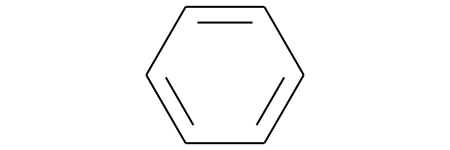

In [45]:
mol

In [44]:
for bond in mol.GetBonds():
    print(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())

0 1
1 2
2 3
3 4
4 5
5 0


In [16]:
def genGraphs(all_data, id_, smilesColumn, targetColumn, MAX_N=64):
    examples = []
    for idx, smi, tar in tqdm(zip(all_data[id_].tolist(), all_data[smilesColumn].tolist(), all_data[targetColumn].tolist())):
        #print(idx)
        molgraphs = {}
        at_begin, at_end = [], []
        atom_feature_list = []
        bond_feature_list = []

        #mol_graph = MolGraph(smi, '1-GNN')
        
        for atom in smi.GetAtoms():
            atom_feature_list.append(atom_features(atom))
        for bond in smi.GetBonds():
            bond_feature_list.append(bond_features_new(bond))
            bond_feature_list.append(bond_features_new(bond))
            at_begin.append(bond.GetBeginAtom().GetIdx())
            at_begin.append(bond.GetEndAtom().GetIdx())
            at_end.append(bond.GetEndAtom().GetIdx())
            at_end.append(bond.GetBeginAtom().GetIdx())
        
        molgraphs['x'] = torch.FloatTensor(atom_feature_list) # atom features 
        molgraphs['edge_attr'] = torch.FloatTensor(bond_feature_list) # bond features 
        molgraphs['edge_index'] = torch.LongTensor(np.concatenate([at_begin, at_end]).reshape(2,-1))
        
        molgraphs['smiles'] = smi
        molgraphs['id'] = torch.FloatTensor([idx])
        
        mask = np.zeros((molgraphs['x'].shape[0], 1), dtype=np.float32)
        vals = np.zeros((molgraphs['x'].shape[0], 1), dtype=np.float32)
        for k, v in tar[0].items():
            mask[int(k), 0] = 1.0
            vals[int(k), 0] = v
        molgraphs['y'] = torch.FloatTensor(vals).flatten()
        molgraphs['mask'] = torch.FloatTensor(mask).flatten()
        examples.append(molgraphs)
        
        #if idx % 100 == 0:
        #print('Finish processing {} compounds'.format(idx))
    print('Done.')
        
    return examples

In [17]:
graphs = genGraphs(all_df, 'molecule_id', 'rdmol', 'value')

12806it [00:44, 288.17it/s]

Done.


In [49]:
torch.save(graphs, '../examples/propertyPrediction/nmr/hydrogen/raw/temp.pt')

## Create data loader for training.

In [8]:
from data import *

In [9]:
config = {'dataset': 'nmr/carbon', # dataset name
          'model': '1-GNN',  # model 
          'train_type': 'from_scratch', 
          'normalize': False,
          'train_size': 1000, 
          'val_size': 123, 
          'batch_size': 16,
          'data_path': '../examples/propertyPrediction/nmr/hydrogen/'}

In [10]:
loader = get_data_loader(config)

In [11]:
print(len(loader.train_loader.dataset)), print(len(loader.val_loader.dataset))

1000
123


(None, None)

## Prepare models for training

In [13]:
from models import *

In [14]:
from trainer import *
from helper import *

In [33]:
config_train = {'num_layer': 3, # atom embedding layers 
                'emb_dim':64, # embedding dimension
                'NumOutLayers': 3, # number of read-out layers
                'num_tasks':1, 
                'pooling': 'sum',
                'gnn_type': 'nnconv', 
                'optimizer': 'adam',
                'lr': 0.001,
                'loss': 'maskedL2',
                'metrics': 'l1', 
                'drop_ratio': 0.,
                'JK': 'last',
                'weights': 'xavier_norm', # weights initialization method 
                'taskType': 'single',
                'propertyLevel': 'atom',
                'EFGS': False,
                'solvent':'',
                'interaction': '',
                'device': torch.device('cpu')
                
}

In [34]:
config.update(config_train)

In [35]:
config

{'dataset': 'nmr/carbon',
 'model': '1-GNN',
 'train_type': 'from_scratch',
 'normalize': False,
 'train_size': 1000,
 'val_size': 123,
 'batch_size': 16,
 'data_path': '../examples/propertyPrediction/nmr/hydrogen/',
 'num_layer': 3,
 'emb_dim': 64,
 'num_readout_layers': 3,
 'num_tasks': 1,
 'graph_pooling': 'sum',
 'gnn_type': 'nnconv',
 'optimizer': 'adam',
 'lr': 0.001,
 'loss': 'maskedL2',
 'metrics': 'l1',
 'drop_ratio': 0.0,
 'JK': 'last',
 'weights': 'xavier_norm',
 'taskType': 'single',
 'propertyLevel': 'atom',
 'EFGS': False,
 'solvent': '',
 'interaction': '',
 'device': device(type='cpu'),
 'NumOutLayers': 3,
 'pooling': 'sum'}

In [36]:
model = get_model(config)

In [37]:
model.to(config['device'])

GNN_1(
  (gnn): GNN(
    (x_embedding1): Sequential(
      (0): Linear(in_features=40, out_features=64, bias=True)
      (1): ReLU()
    )
    (gnns): ModuleList(
      (0): NNCon(
        (edge_embedding1): Embedding(6, 64)
        (edge_embedding2): Embedding(4, 64)
        (conv_): NNConv(64, 64)
      )
      (1): NNCon(
        (edge_embedding1): Embedding(6, 64)
        (edge_embedding2): Embedding(4, 64)
        (conv_): NNConv(64, 64)
      )
      (2): NNCon(
        (edge_embedding1): Embedding(6, 64)
        (edge_embedding2): Embedding(4, 64)
        (conv_): NNConv(64, 64)
      )
    )
    (batch_norms): ModuleList(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (outLayers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=6

In [38]:
model = init_weights(model, config)

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

In [40]:
for epoch in range(1, 100):
    loss = train(model, optimizer, loader.train_loader, config)
    #print(loss)
    train_error = test(model, loader.train_loader, config)
    #val_error = 0.
    val_error = test(model, loader.val_loader, config)
    #test_error = test(model, loader.test_loader, config)
    #test_error = 0.
    print("Train loss is {} and val error is {} and val error is {} at epoch {}".format(loss, train_error, val_error, epoch))

Train loss is 2.2709293365478516 and val error is 0.9689146677652994 and val error is 0.9244341966582508 at epoch 1
Train loss is 0.7832245230674744 and val error is 0.6122402422355883 and val error is 0.6669253837771532 at epoch 2
Train loss is 0.6145329475402832 and val error is 0.6224354252670751 and val error is 0.684511603378668 at epoch 3
Train loss is 0.48110538721084595 and val error is 0.6762602257006096 and val error is 0.8071994316287157 at epoch 4
Train loss is 0.6878549456596375 and val error is 0.6279304966782079 and val error is 0.6736039882752953 at epoch 5
Train loss is 1.2578308582305908 and val error is 0.5878243301853989 and val error is 0.6403601111435309 at epoch 6
Train loss is 0.8931701183319092 and val error is 0.6096532995050604 and val error is 0.6427620213206221 at epoch 7
Train loss is 0.5441385507583618 and val error is 0.6626265554717092 and val error is 0.691843405002501 at epoch 8
Train loss is 1.6684919595718384 and val error is 0.6510038086862275 and 

KeyboardInterrupt: 

In [ ]:
Chem.MolF